<b>Universidad Galileo</b><br/>
<b>Maestría de Ciencia de Datos</b><br/>
<b>Statistical Learning I</b><br/>
<b>Jose Godoy</b><br/>
<b>Carnet 22000570</b><br/>
<b>22 de junio 2022</b><br/>

# 1. Sección de configuración

## 1.1 Librerías

Carga de librerías generales

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
from IPython.display import Image

Cargando librerías de sklearn:

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, recall_score, f1_score
from sklearn import svm

Cargando librerías de TensorFlow

In [114]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
tf.enable_eager_execution()
from tensorflow.keras.callbacks import TensorBoard

Variable de entorno tf

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Graficas más grandes

In [5]:
plt.rcParams["figure.figsize"] = (16, 4)

Para guardar modelos y funciones

In [6]:
import pickle

## 1.2 Variables Globales

In [7]:
#Exactitud utilizada en todos los modelos
GLOBAL_EXACTITUD = 0.8
#Datos CSV sin alterar
GLOBAL_DATOS = pd.read_csv("data_titanic_proyecto.csv")
#Porcentaje de datos de entrenamiento
GLOBAL_SET_ENTRENAMIENTO = 0.8
#Porcentaje de datos de validación
GLOBAL_SET_VALIDACION = 0.2

Tabla de predicciones

In [8]:
tabla_predicciones = pd.DataFrame()

# 2. Preprocesamiento

## 2.1 Train-val-test split

In [9]:
TVTS_data = GLOBAL_DATOS.copy()
TVTS_data.shape

(891, 12)

Indices aleatorios

In [10]:
np.random.seed(2022)

Indices prueba

In [11]:
longitud = len(TVTS_data)
TVTS_indices_entrenamiento = np.random.choice(longitud, round(longitud * GLOBAL_SET_ENTRENAMIENTO), replace=False)
TVTS_indices_prueba = np.array(list(set(range(longitud)) - set(TVTS_indices_entrenamiento)))

Datos prueba

In [12]:
TVTS_data_prueba = TVTS_data.iloc[TVTS_indices_prueba,:].copy()
TVTS_data_entrenamiento = TVTS_data.iloc[TVTS_indices_entrenamiento,:]

Indices de entrenamiento y validación

In [13]:
longitud = len(TVTS_data_entrenamiento)
TVTS_indices_validacion = np.random.choice(longitud, round(longitud * GLOBAL_SET_VALIDACION), replace=False)
TVTS_indices_entrenamiento = np.array(list(set(range(longitud)) - set(TVTS_indices_validacion)))

Datos de entrenamiento y validación

In [14]:
TVTS_data_validacion = TVTS_data_entrenamiento.iloc[TVTS_indices_validacion,:].copy()
TVTS_data_entrenamiento = TVTS_data_entrenamiento.iloc[TVTS_indices_entrenamiento,:].copy()

Guardando CSV de datos de prueba

In [15]:
TVTS_data_prueba.to_csv("TVTS_data_prueba.csv", index=False)

Eliminación de variables con los datos de prueba:

In [16]:
del TVTS_data_prueba
del TVTS_data
del GLOBAL_DATOS

## 2.2 Analisis exploratorio

Los datos son los siguientes:

In [17]:
AE_feature_engineering = TVTS_data_entrenamiento.copy()
AE_feature_engineering

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
770,771,"Lievens, Mr. Rene Aime",24.00,0,0,345781,9.5000,NaN,S,Lower,M,N
178,179,"Hale, Mr. Reginald",30.00,0,0,250653,13.0000,NaN,S,Middle,M,N
159,160,"Sage, Master. Thomas Henry",NaN,8,2,CA. 2343,69.5500,NaN,S,Lower,M,N
656,657,"Radeff, Mr. Alexander",NaN,0,0,349223,7.8958,NaN,S,Lower,M,N
471,472,"Cacic, Mr. Luka",38.00,0,0,315089,8.6625,NaN,S,Lower,M,N
...,...,...,...,...,...,...,...,...,...,...,...,...
803,804,"Thomas, Master. Assad Alexander",0.42,0,1,2625,8.5167,NaN,C,Lower,M,Y
445,446,"Dodge, Master. Washington",4.00,0,2,33638,81.8583,A34,S,Upper,M,Y
365,366,"Adahl, Mr. Mauritz Nils Martin",30.00,0,0,C 7076,7.2500,NaN,S,Lower,M,N
611,612,"Jardin, Mr. Jose Neto",NaN,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S,Lower,M,N


### 2.2.1 Eliminación de características específicas

Se eliminará ID de pasajero "passengerID" y nombre.

In [18]:
del AE_feature_engineering["PassengerId"]
del AE_feature_engineering["Name"]

### 2.2.2 Imputación de datos faltantes

A continuación se listan la cantidad de registros en cada columna que tienen valores NAN:

In [19]:
for col in AE_feature_engineering.columns:
    AE_columnas_nan = AE_feature_engineering[col].isnull().sum().sum()
    if(AE_columnas_nan>0):
        print(col+":", AE_columnas_nan)

Age: 112
Cabin: 445
Embarked: 1


#### 2.2.2.1 Analisis de densidad de la columna Year:

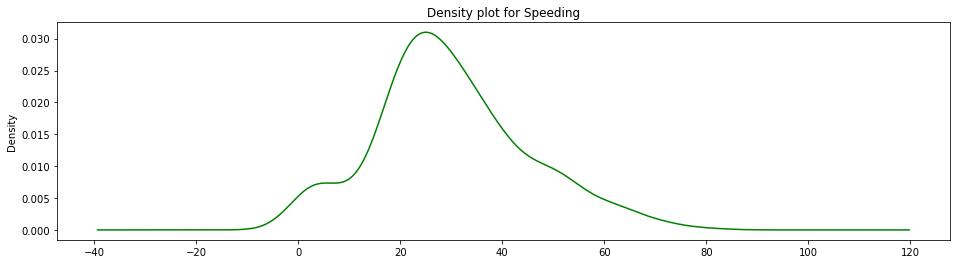

In [20]:
AE_age_nonan = AE_feature_engineering["Age"].notnull()
AE_feature_engineering["Age"][AE_age_nonan].plot.density(color='green')
plt.title('Density plot for Speeding')
plt.show()

Se utilizará un numero aleatorio utilizando una distribución normal. No se utilizará la media para no crear un outlayer:

In [21]:
AE_age_nan = AE_feature_engineering["Age"].isnull()
AE_age_mean = AE_feature_engineering["Age"][AE_age_nonan].mean(axis=0)
AE_age_std = AE_feature_engineering["Age"][AE_age_nonan].std(axis=0)
AE_age_random = np.random.normal(AE_age_mean, AE_age_std, sum(AE_age_nan))

AE_feature_engineering.columns.get_loc("Age")

AE_feature_engineering.loc[AE_age_nan, "Age"] = AE_age_random

#### 2.2.2.2 Analisis de la columna categórica Cabin

Porcentaje de datos faltantes:

In [22]:
print(sum(AE_feature_engineering["Cabin"].isnull())*100/len(AE_feature_engineering["Cabin"]))

78.0701754385965


En el siguiente gráfico se visualiza la gráfica de densidad para Cabin:

<AxesSubplot:>

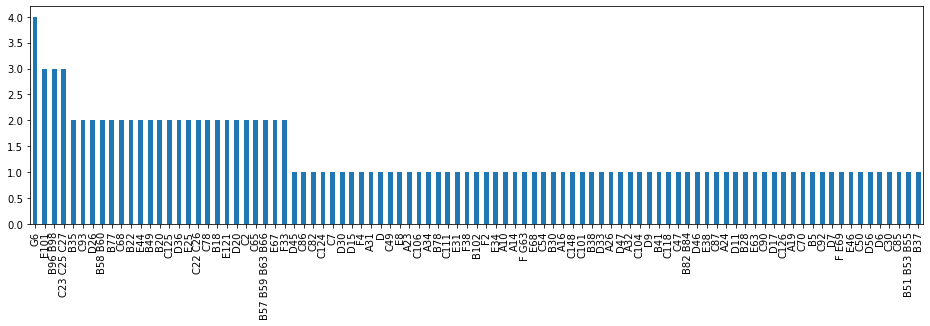

In [23]:
AE_cabin_nonan = AE_feature_engineering["Cabin"].notnull()
AE_cabin_repitencia = AE_feature_engineering["Cabin"][AE_cabin_nonan].value_counts()
AE_cabin_repitencia.plot(kind='bar')

La reptiencia máxima de Cabin es 'G6', este valor aparece solo 4 veces. Es necesario considerar que solo se tienen 4 registros con est

In [24]:
print("Registros que se repiten 4 veces:", len(AE_cabin_repitencia[AE_cabin_repitencia==4])/len(AE_cabin_repitencia))
print("Registros que se repiten 3 veces:", len(AE_cabin_repitencia[AE_cabin_repitencia==3])/len(AE_cabin_repitencia))
print("Registros que se repiten 2 veces:", len(AE_cabin_repitencia[AE_cabin_repitencia==2])/len(AE_cabin_repitencia))
print("Registros que se repiten 1 vez:", len(AE_cabin_repitencia[AE_cabin_repitencia==1])/len(AE_cabin_repitencia))

Registros que se repiten 4 veces: 0.010752688172043012
Registros que se repiten 3 veces: 0.03225806451612903
Registros que se repiten 2 veces: 0.24731182795698925
Registros que se repiten 1 vez: 0.7096774193548387


Para la columna Kabin se considera que no existe suficiente información para hacer imputación de datos. Se eliminará la columna.

In [25]:
del AE_feature_engineering["Cabin"]

#### 2.2.2.3 Analisis de densidad de la columna Embarked:

Existen pocos valores nan en la columna Embarked, a continuación se lista la repitencia de valores para esta columna:

In [26]:
AE_embarked_nonan = AE_feature_engineering["Embarked"].notnull()
AE_embarked_repitencia = AE_feature_engineering["Embarked"][AE_cabin_nonan].value_counts()
AE_embarked_repitencia

S    74
C    46
Q     4
Name: Embarked, dtype: int64

Se realizará imputación con el valor más repetido:

In [27]:
AE_embarked_mas_repetido = AE_embarked_repitencia[AE_embarked_repitencia==AE_embarked_repitencia[0]].axes[0].tolist()
AE_embarked_nan = AE_feature_engineering["Embarked"].isnull()
AE_feature_engineering.loc[AE_embarked_nan, "Embarked"] = AE_embarked_mas_repetido

### 2.2.3 Codificación de variables categóricas

El dataset hasta ahora es:

In [28]:
AE_feature_engineering

,Age,SibSp,Parch,Ticket,Fare,Embarked,passenger_class,passenger_sex,passenger_survived
770,24.000000,0,0,345781,9.5000,S,Lower,M,N
178,30.000000,0,0,250653,13.0000,S,Middle,M,N
159,38.841137,8,2,CA. 2343,69.5500,S,Lower,M,N
656,36.479933,0,0,349223,7.8958,S,Lower,M,N
471,38.000000,0,0,315089,8.6625,S,Lower,M,N
...,...,...,...,...,...,...,...,...,...
803,0.420000,0,1,2625,8.5167,C,Lower,M,Y
445,4.000000,0,2,33638,81.8583,S,Upper,M,Y
365,30.000000,0,0,C 7076,7.2500,S,Lower,M,N
611,36.444048,0,0,SOTON/O.Q. 3101305,7.0500,S,Lower,M,N


#### 2.2.3.1 Columna Ticket

A continuación se muestra la repetición de cada valor único:

In [29]:
AE_feature_engineering.Ticket.value_counts()

CA. 2343        5
1601            5
CA 2144         5
3101295         5
S.O.C. 14879    5
               ..
363592          1
24160           1
C.A. 6212       1
248747          1
11771           1
Name: Ticket, Length: 468, dtype: int64

La columna ticket será reemplazada según su repetición.

In [30]:
AE_valores_Ticket = AE_feature_engineering.Ticket.value_counts().axes[0].tolist()
AE_repitencia_Ticket = np.array(AE_feature_engineering.Ticket.value_counts())
AE_feature_engineering['Ticket'].replace(AE_valores_Ticket, AE_repitencia_Ticket, inplace=True)

#### 2.2.3.2 Columna Embarked

A continuación se muestra la repetición de cada valor único:

In [31]:
AE_feature_engineering.Embarked.value_counts()

S    406
C    106
Q     58
Name: Embarked, dtype: int64

La columna ticket será reemplazada utilizando one hot encoding.

In [32]:
AE_Embarked_OHE = pd.get_dummies(AE_feature_engineering.Embarked, prefix="Embarked")
AE_feature_engineering = pd.concat([AE_feature_engineering, AE_Embarked_OHE], axis=1)
del AE_feature_engineering["Embarked"]

#### 2.2.3.3 Columna passenger_class

A continuación se muestra la repetición de cada valor único:

In [33]:
AE_feature_engineering.passenger_class.value_counts()

Lower     314
Upper     132
Middle    124
Name: passenger_class, dtype: int64

La columna ticket será reemplazada utilizando one hot encoding.

In [34]:
AE_passenger_class_OHE = pd.get_dummies(AE_feature_engineering.passenger_class, prefix="passenger_class")
AE_feature_engineering = pd.concat([AE_feature_engineering, AE_passenger_class_OHE], axis=1)
del AE_feature_engineering["passenger_class"]

#### 2.2.3.3 Columna passenger_sex

A continuación se muestra la repetición de cada valor único:

In [35]:
AE_feature_engineering.passenger_sex.value_counts()

M    375
F    195
Name: passenger_sex, dtype: int64

Al ser una variable binaria, se representará de la siguiente forma: 1 = es hombre, 0 es mujer.

In [36]:
AE_sexo = AE_feature_engineering["passenger_sex"] == "M"
AE_feature_engineering["passenger_sex"] = AE_sexo.astype('int')

#### 2.2.3.3 Columna passenger_survived

A continuación se muestra la repetición de cada valor único:

In [37]:
AE_feature_engineering.passenger_survived.value_counts()

N    349
Y    221
Name: passenger_survived, dtype: int64

Esta es la variable que se debe predecir en el modelo con clasificación binaria, se utilizará 1 = Y (sobrevivió) y 0 = N (no sobrevivió).

In [38]:
AE_sobrevivio = AE_feature_engineering["passenger_survived"] == "Y"

### 2.2.4 Tratamiento de Outliers

#### 2.2.4.1 Función para outliers

Función para tratar outlayers

In [39]:
def AE_tratamiento_outlier(AE_dataframe, AE_columnas):
    AE_parametros_outliers = pd.DataFrame()
    for AE_columna in AE_columnas:
        AE_quartiles = np.array( AE_dataframe[AE_columna].quantile([.25, .5, .75]) )
        AE_irq = AE_quartiles[2] - AE_quartiles[0]
        AE_limite_inferior = AE_quartiles[0] - AE_irq*1.5
        AE_limite_superior = AE_quartiles[2] + AE_irq*1.5
        AE_mean_to = AE_dataframe[AE_columna].mean(axis=0)
        AE_median_to = AE_dataframe[AE_columna].median(axis=0)
        
        AE_parametros_outliers = pd.concat([
            AE_parametros_outliers, 
            pd.DataFrame(data = {
                "columna": [AE_columna],
                "limite_inferior": [AE_limite_inferior], 
                "limite_superior": [AE_limite_superior], 
                "mean": [AE_mean_to], 
                "median": [AE_median_to]
            })
        ], ignore_index=True)
        
        AE_dataframe.loc[ AE_dataframe[AE_columna] <  AE_limite_inferior, AE_columna ] = AE_mean_to
        AE_dataframe.loc[ AE_dataframe[AE_columna] >  AE_limite_superior, AE_columna ] = AE_median_to
    return AE_parametros_outliers

#### 2.2.4.2 Gráfica BoxPlot

Gráficando BoxPlot para ver los outliers de las variables que no son one hot encoding:

<AxesSubplot:>

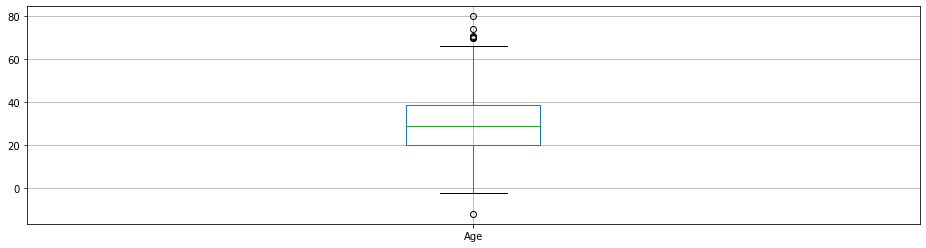

In [40]:
AE_feature_engineering.boxplot(column=['Age']) 

<AxesSubplot:>

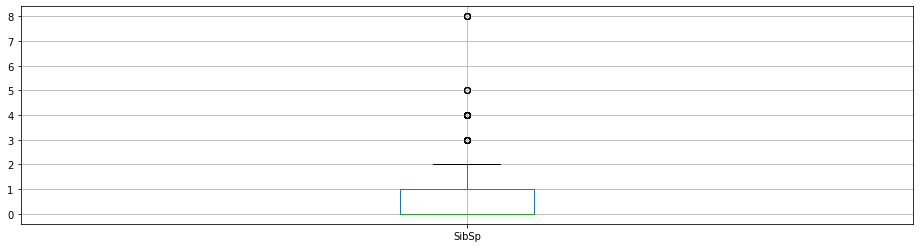

In [41]:
AE_feature_engineering.boxplot(column=['SibSp']) 

<AxesSubplot:>

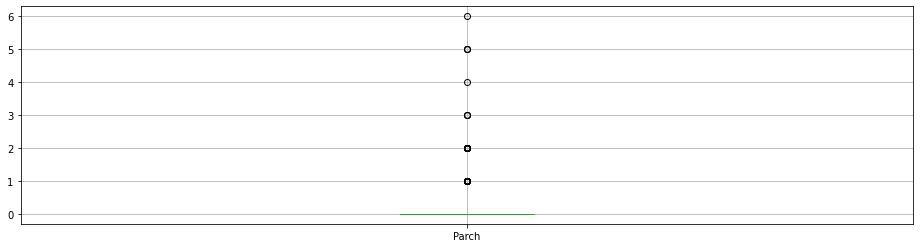

In [42]:
AE_feature_engineering.boxplot(column=['Parch']) 

<AxesSubplot:>

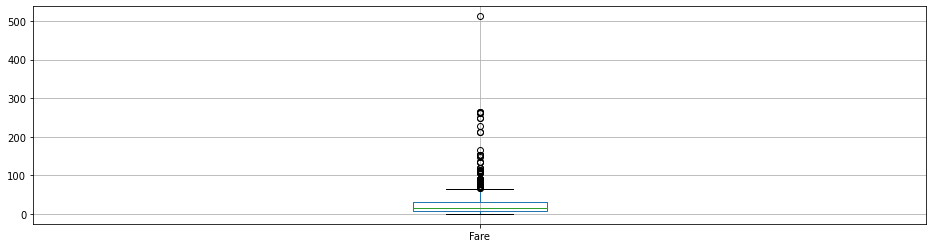

In [43]:
AE_feature_engineering.boxplot(column=['Fare']) 

#### 2.2.4.3 Eliminando outliers

In [44]:
AE_parametros_outliers = AE_tratamiento_outlier(AE_feature_engineering, ['Fare','Parch','SibSp', 'Age']) 

Parametros para tratamiento de outliers obtenidos:

In [45]:
AE_parametros_outliers

,columna,limite_inferior,limite_superior,mean,median
0,Fare,-26.760500,65.656300,31.695533,14.427100
1,Parch,0.000000,0.000000,0.387719,0.000000
2,SibSp,-1.500000,2.500000,0.538596,0.000000
3,Age,-7.386288,66.228617,29.849566,28.989187


Es posible ver cómo el límite inferior y superior de la columna Parch es 0. Esta columna no contiene información que sea de valor para el modelo. Se eliminará.

In [46]:
del AE_feature_engineering["Parch"]

### 2.2.4 Featuring scaling

Antes de normalizar lso datos se creará una gráfica de densidad para cada columna:

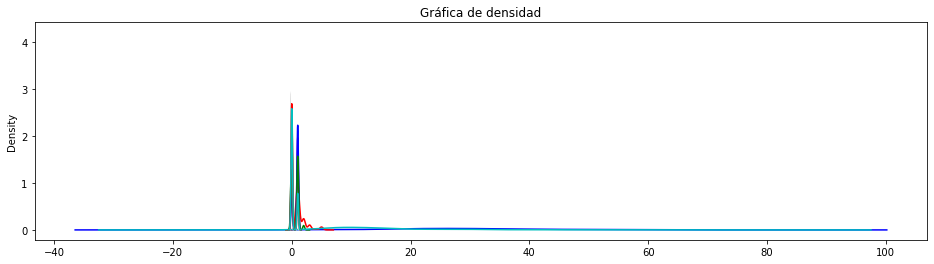

In [47]:
colors = "bgrcmykwbgrcmy"
index=0
for col in AE_feature_engineering.columns:
    if(col!="passenger_survived"):
        AE_feature_engineering[col].plot.density(color=colors[index]) 
    index+=1 
plt.title('Gráfica de densidad') 
plt.show()

Estadísticos:

In [48]:
AE_statistics = AE_feature_engineering.describe()
AE_statistics = pd.concat([AE_statistics.loc["mean",:], AE_statistics.loc["std",:]], axis=1).transpose()
AE_statistics

,Age,SibSp,Ticket,Fare,passenger_sex,Embarked_C,Embarked_Q,Embarked_S,passenger_class_Lower,passenger_class_Middle,passenger_class_Upper
mean,29.464296,0.301754,1.533333,17.062253,0.657895,0.185965,0.101754,0.712281,0.550877,0.217544,0.231579
std,14.109149,0.530441,1.004267,12.508324,0.474831,0.389420,0.302591,0.453097,0.497842,0.412938,0.422212


Normalizando:

In [49]:
AE_feature_engineering = (AE_feature_engineering.iloc[:,AE_feature_engineering.columns!="passenger_survived"] - AE_statistics.loc["mean"]) / AE_statistics.loc["std"]
AE_feature_engineering["passenger_survived"] = AE_sobrevivio.astype('int')
AE_feature_engineering

,Age,SibSp,Ticket,Fare,passenger_sex,Embarked_C,Embarked_Q,Embarked_S,passenger_class_Lower,passenger_class_Middle,passenger_class_Upper,passenger_survived
770,-0.387287,-0.568874,-0.531067,-0.604578,0.720477,-0.477543,-0.336277,0.635006,0.902140,-0.526820,-0.548490,0
178,0.037969,-0.568874,-0.531067,-0.324764,0.720477,-0.477543,-0.336277,0.635006,-1.106531,1.894852,-0.548490,0
159,0.664593,-0.568874,3.451936,-0.210672,0.720477,-0.477543,-0.336277,0.635006,0.902140,-0.526820,-0.548490,0
656,0.497240,-0.568874,-0.531067,-0.732828,0.720477,-0.477543,-0.336277,0.635006,0.902140,-0.526820,-0.548490,0
471,0.604977,-0.568874,-0.531067,-0.671533,0.720477,-0.477543,-0.336277,0.635006,0.902140,-0.526820,-0.548490,0
...,...,...,...,...,...,...,...,...,...,...,...,...
803,-2.058543,-0.568874,-0.531067,-0.683189,0.720477,2.090378,-0.336277,-1.572026,0.902140,-0.526820,-0.548490,1
445,-1.804807,-0.568874,-0.531067,-0.210672,0.720477,-0.477543,-0.336277,0.635006,-1.106531,-0.526820,1.819989,1
365,0.037969,-0.568874,-0.531067,-0.784458,0.720477,-0.477543,-0.336277,0.635006,0.902140,-0.526820,-0.548490,0
611,0.494697,-0.568874,-0.531067,-0.800447,0.720477,-0.477543,-0.336277,0.635006,0.902140,-0.526820,-0.548490,0


Si volvemos a graficar el dataframe, los datos estarán correctamente escalados:

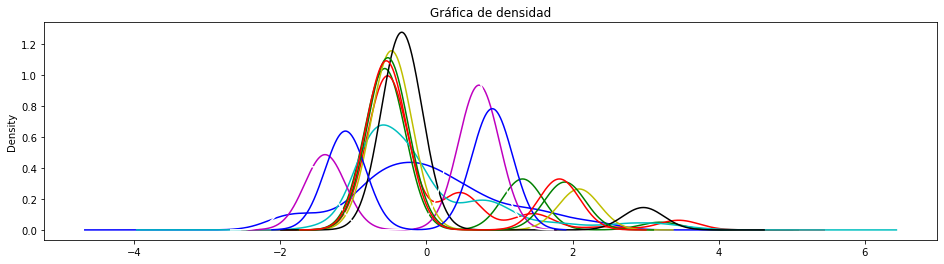

In [50]:
colors = "bgrcmykwbgrcmy"
index=0
for col in AE_feature_engineering.columns:
    if(col!="passenger_survived"):
        AE_feature_engineering[col].plot.density(color=colors[index]) 
    index+=1 
plt.title('Gráfica de densidad') 
plt.show()

### 2.2.5 Análisis de correlación

Tabla de correlación:

In [51]:
#Correlación
AE_correlacion = AE_feature_engineering.corr()
pd.DataFrame(AE_correlacion["passenger_survived"].abs().sort_values(ascending=False))

,passenger_survived
passenger_survived,1.000000
passenger_sex,0.572235
passenger_class_Lower,0.280468
passenger_class_Upper,0.271617
Embarked_C,0.174927
SibSp,0.171975
Embarked_S,0.154418
Fare,0.125201
Age,0.092847
passenger_class_Middle,0.060419


La tabla de correlación se utilizará para decidir que columnas utilizar en cada experimento.

# 3. Entrenamiento

Variables con la data de entrenamiento y validación:

In [52]:
E_data_entrenamiento = AE_feature_engineering.copy()
E_data_validacion = TVTS_data_validacion.copy()

Función para separar el dataset en features y target

In [53]:
def E_separar_y_x(E_df):
    E_df_copy = E_df.copy()
    E_spyx_target = pd.DataFrame(E_df_copy["passenger_survived"])
    del E_df_copy["passenger_survived"]
    return [E_df_copy, E_spyx_target]

Separación de información para para entrenamiento:

In [54]:
E_train_features, E_train_target = E_separar_y_x( E_data_entrenamiento )

Función de pre-procesamiento de datos para el set de validación

In [55]:
def E_pre_procesamiento(
    E_pp_validacion, 
    E_pp_age_mean, 
    E_pp_age_std, 
    E_pp_embarked_mas_repetido, 
    E_pp_statistics, 
    E_pp_tratamiento_outlier):
    
    #Eliminación de columnas no utilizadas
    del E_pp_validacion["PassengerId"]
    del E_pp_validacion["Name"]
    del E_pp_validacion["Cabin"]
    del E_pp_validacion["Parch"]
    
    #Imputación de datos
    
    #Columna Año
    E_pp_age_nan = E_pp_validacion["Age"].isnull()
    if(len(E_pp_age_nan)>0):
        E_pp_age_random = np.random.normal(E_pp_age_mean, E_pp_age_std, sum(E_pp_age_nan))
        E_pp_validacion.loc[E_pp_age_nan, "Age"] = E_pp_age_random
    
    #Columna Ticket
    E_pp_valores_Ticket = E_pp_validacion.Ticket.value_counts().axes[0].tolist()
    E_pp_repitencia_Ticket = np.array(E_pp_validacion.Ticket.value_counts())
    E_pp_validacion['Ticket'].replace(E_pp_valores_Ticket, E_pp_repitencia_Ticket, inplace=True)
    
    #Columna Embarked
    E_pp_embarked_nan = E_pp_validacion["Embarked"].isnull()
    if(len(E_pp_embarked_nan)>0):
        E_pp_validacion.loc[E_pp_embarked_nan, "Embarked"] = E_pp_embarked_mas_repetido
    
    #Columnas categórias
    
    #Columna Embarked
    E_pp_Embarked_OHE = pd.get_dummies(E_pp_validacion.Embarked, prefix="Embarked")
    E_pp_validacion = pd.concat([E_pp_validacion, E_pp_Embarked_OHE], axis=1)
    del E_pp_validacion["Embarked"]
    
    #Columna passenger_class
    E_pp_passenger_class_OHE = pd.get_dummies(E_pp_validacion.passenger_class, prefix="passenger_class")
    E_pp_validacion = pd.concat([E_pp_validacion, E_pp_passenger_class_OHE], axis=1)
    del E_pp_validacion["passenger_class"]
    
    #Columna passenger_sex
    E_pp_sexo = E_pp_validacion["passenger_sex"] == "M"
    E_pp_validacion["passenger_sex"] = E_pp_sexo.astype('int')
    
    #Columna passenger_survived
    E_pp_sobrevivio = E_pp_validacion["passenger_survived"] == "Y"
    
    #Tratamiento de outliers
    E_pp_tratamiento_outlier(E_pp_validacion, ['Fare','SibSp', 'Age']) 
    
    #Featuring scaling
    E_pp_validacion = (E_pp_validacion.iloc[:,E_pp_validacion.columns!="passenger_survived"] - E_pp_statistics.loc["mean"]) / E_pp_statistics.loc["std"]
    E_pp_validacion["passenger_survived"] = E_pp_sobrevivio.astype('int')
    
    return E_pp_validacion

Guardando estadísticos:

In [56]:
pickle.dump(AE_age_mean, open("modelos_y_estadisticos/AE_age_mean", 'wb'))
pickle.dump(AE_age_std, open("modelos_y_estadisticos/AE_age_std", 'wb'))
pickle.dump(AE_embarked_mas_repetido, open("modelos_y_estadisticos/AE_embarked_mas_repetido", 'wb'))
pickle.dump(AE_statistics, open("modelos_y_estadisticos/AE_statistics", 'wb'))

Pre-procesamiento y separación de información para validación

In [57]:
#Preprocesamiento
E_data_validacion = E_pre_procesamiento(
    E_data_validacion, 
    AE_age_mean, 
    AE_age_std, 
    AE_embarked_mas_repetido, 
    AE_statistics, 
    AE_tratamiento_outlier
)

#Separación
E_validation_features, E_validation_target = E_separar_y_x( E_data_validacion )

Función para identificar overfitting o underfitting

In [58]:
def E_identificar_sobre_entrenamiento(E_yhat, E_y):
    plt.plot(range(len(E_yhat)), E_yhat)
    plt.plot(range(len(E_yhat)), np.array(E_y))
    plt.show()

Función para generar metricas y guardar resultados de experimento:

In [59]:
def E_guardar_metricas(exp_id, E_yhat, E_y, E_cadena, E_columnas, E_modelo_nombre):
    E_resultados_exp = pd.DataFrame([{
        'ID': exp_id, 
        'Fecha Hora': datetime.datetime.now(),
        'Modelo': E_modelo_nombre,
        'Experimento': E_cadena,
        'MSE': mean_squared_error(np.array(E_y), E_yhat),
        'Accuracy Score': accuracy_score(np.array(E_y), E_yhat),
        'Recall Score': recall_score(np.array(E_y), E_yhat),
        'F1 Score': f1_score(np.array(E_y), E_yhat),
        'Age': E_columnas[0],
        'SibSp': E_columnas[1],
        'Ticket': E_columnas[2],
        'Fare': E_columnas[3],
        'passenger_sex': E_columnas[4],
        'Embarked_C': E_columnas[5],
        'Embarked_Q': E_columnas[6],
        'Embarked_S': E_columnas[7],
        'passenger_class_Lower': E_columnas[8],
        'passenger_class_Middle': E_columnas[9],
        'passenger_class_Upper': E_columnas[10]
    }])
    E_resultados_exp.to_csv('experimentos.csv', mode='a', index=False, header=(not os.path.exists('experimentos.csv')))
    return E_resultados_exp

## 3.1 Arbol de decision

Función para crear el modelo de arbol de desición

In [60]:
def EAD_arbol_decision(EAD_ad_x, EAD_ad_y, EAD_x_columnas):
    EAD_ad_modelo = DecisionTreeClassifier()
    EAD_ad_modelo.fit(EAD_ad_x.iloc[:,EAD_x_columnas], EAD_ad_y)
    return EAD_ad_modelo

### 3.1.1 Experimento 1 - Todos los features

Creación y predicción del arbol de desición con todas las columnas

In [61]:
EAD_columnas = np.full(len(E_train_features.columns), True)
EAD_ad_modelo = EAD_arbol_decision(E_train_features, E_train_target, EAD_columnas)
EAD_prediccion = EAD_ad_modelo.predict(E_validation_features.iloc[:,EAD_columnas])

Resultados del experimento 1:

In [62]:
EAD_modelo_nombre = "Decision Tree"
EAD_cadena = "Exp1_All"
EAD_metricas_evaluacion = E_guardar_metricas("Tree1", EAD_prediccion, E_validation_target, EAD_cadena, EAD_columnas, EAD_modelo_nombre)
EAD_metricas_evaluacion

,ID,Fecha Hora,Modelo,Experimento,MSE,Accuracy Score,Recall Score,F1 Score,Age,SibSp,Ticket,Fare,passenger_sex,Embarked_C,Embarked_Q,Embarked_S,passenger_class_Lower,passenger_class_Middle,passenger_class_Upper
0,Tree1,2022-06-30 22:00:10.071294,Decision Tree,Exp1_All,0.237762,0.762238,0.689655,0.701754,True,True,True,True,True,True,True,True,True,True,True


Previsualización de predicción para estimar overfit o underfit:

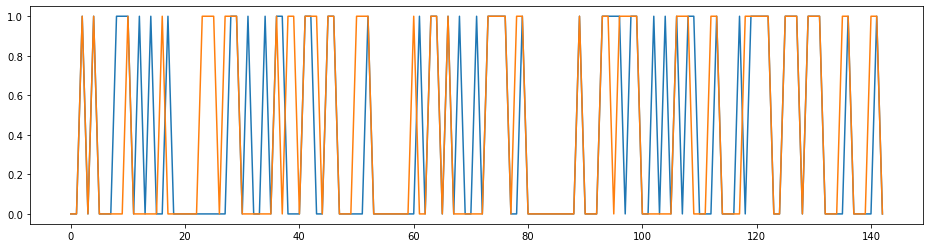

In [63]:
E_identificar_sobre_entrenamiento(EAD_prediccion, E_validation_target)

Agregando resultados a tabla de predicción:

In [64]:
tabla_predicciones["Y"] = E_validation_target
tabla_predicciones["Tree1"] = EAD_prediccion

### 3.1.2 Experimento 2 - Features con correlación > 0.5

Creación y predicción del arbol de desición utilizando los valores que tengan un valor de correlación mayor a 0.5 para con la columna passenger_survived:

In [65]:
EAD_columnas = np.array(np.abs(AE_correlacion.loc["passenger_survived", E_train_features.columns])>0.5)
EAD_ad_modelo = EAD_arbol_decision(E_train_features, E_train_target, EAD_columnas)
EAD_prediccion = EAD_ad_modelo.predict(E_validation_features.iloc[:,EAD_columnas])

Resultados del experimento 2:

In [66]:
EAD_modelo_nombre = "Decision Tree"
EAD_cadena = "Exp2_Corr>0.5"
EAD_metricas_evaluacion = E_guardar_metricas("Tree2", EAD_prediccion, E_validation_target, EAD_cadena, EAD_columnas, EAD_modelo_nombre)
EAD_metricas_evaluacion

,ID,Fecha Hora,Modelo,Experimento,MSE,Accuracy Score,Recall Score,F1 Score,Age,SibSp,Ticket,Fare,passenger_sex,Embarked_C,Embarked_Q,Embarked_S,passenger_class_Lower,passenger_class_Middle,passenger_class_Upper
0,Tree2,2022-06-30 22:00:10.278154,Decision Tree,Exp2_Corr>0.5,0.20979,0.79021,0.689655,0.727273,False,False,False,False,True,False,False,False,False,False,False


Previsualización de predicción para estimar overfit o underfit:

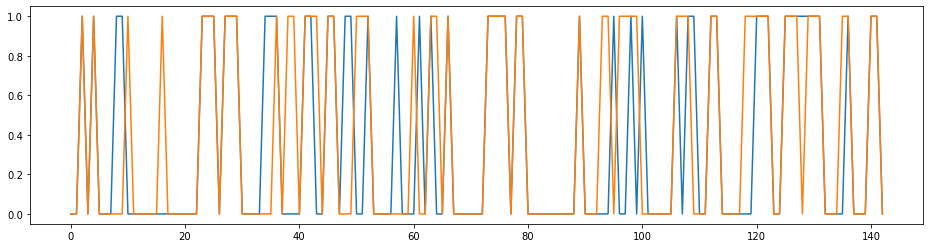

In [67]:
E_identificar_sobre_entrenamiento(EAD_prediccion, E_validation_target)

Agregando resultados a tabla de predicción:

In [68]:
tabla_predicciones["Tree2"] = EAD_prediccion

# 3.1.3 Experimento 3 - Features con correlación passenger_sex > 0.1 


En el experimento 2 se comprobo que la predicción se basa en el sexo de la persona. A continuación se utilizaran los features con valor de correlación mayor a 0.1 para con la columna passenger_sex:

In [69]:
EAD_columnas = np.array(np.abs(AE_correlacion.loc["passenger_sex", E_train_features.columns])>0.1)
EAD_ad_modelo = EAD_arbol_decision(E_train_features, E_train_target, EAD_columnas)
EAD_prediccion = EAD_ad_modelo.predict(E_validation_features.iloc[:,EAD_columnas])

Resultados del experimento 3:

In [70]:
EAD_modelo_nombre = "Decision Tree"
EAD_cadena = "Exp3_CorrSex>0.1"
EAD_metricas_evaluacion = E_guardar_metricas("Tree3", EAD_prediccion, E_validation_target, EAD_cadena, EAD_columnas, EAD_modelo_nombre)
EAD_metricas_evaluacion

,ID,Fecha Hora,Modelo,Experimento,MSE,Accuracy Score,Recall Score,F1 Score,Age,SibSp,Ticket,Fare,passenger_sex,Embarked_C,Embarked_Q,Embarked_S,passenger_class_Lower,passenger_class_Middle,passenger_class_Upper
0,Tree3,2022-06-30 22:00:10.515521,Decision Tree,Exp3_CorrSex>0.1,0.202797,0.797203,0.603448,0.707071,False,True,False,False,True,False,False,True,True,False,True


Previsualización de predicción para estimar overfit o underfit:

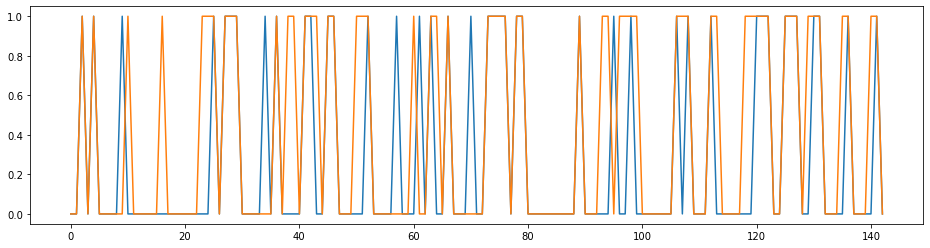

In [71]:
E_identificar_sobre_entrenamiento(EAD_prediccion, E_validation_target)

Agregando resultados a tabla de predicción:

In [72]:
tabla_predicciones["Tree3"] = EAD_prediccion

Guardando modelo:

In [73]:
pickle.dump(EAD_ad_modelo, open("modelos_y_estadisticos/Model_Tree3", 'wb'))
pickle.dump(EAD_columnas, open("modelos_y_estadisticos/Model_Tree3_EAD_columnas", 'wb'))

## 3.2 SVM

Función para crear el modelo SVM

In [74]:
def ESVM_SVM(ESVM_s_x, ESVM_s_y, ESVM_x_columnas):
    ESVM_s_modelo = svm.SVC()
    ESVM_s_modelo.fit(ESVM_s_x.iloc[:,ESVM_x_columnas], ESVM_s_y.values.ravel())
    return ESVM_s_modelo

### 3.2.1 Experimento 1 - Todos los features

Creación y predicción SVM con todas las columnas

In [75]:
ESVM_columnas = np.full(len(E_train_features.columns), True)
ESVM_svm_modelo = ESVM_SVM(E_train_features, E_train_target, ESVM_columnas)
ESVM_prediccion = ESVM_svm_modelo.predict(E_validation_features.iloc[:,ESVM_columnas])

Resultados del experimento 1:

In [76]:
ESVM_modelo_nombre = "SVM"
ESVM_cadena = "Exp1_All"
ESVM_metricas_evaluacion = E_guardar_metricas("SVM4", ESVM_prediccion, E_validation_target, ESVM_cadena, ESVM_columnas, ESVM_modelo_nombre)
ESVM_metricas_evaluacion

,ID,Fecha Hora,Modelo,Experimento,MSE,Accuracy Score,Recall Score,F1 Score,Age,SibSp,Ticket,Fare,passenger_sex,Embarked_C,Embarked_Q,Embarked_S,passenger_class_Lower,passenger_class_Middle,passenger_class_Upper
0,SVM4,2022-06-30 22:00:10.762188,SVM,Exp1_All,0.216783,0.783217,0.706897,0.725664,True,True,True,True,True,True,True,True,True,True,True


Previsualización de predicción para estimar overfit o underfit:

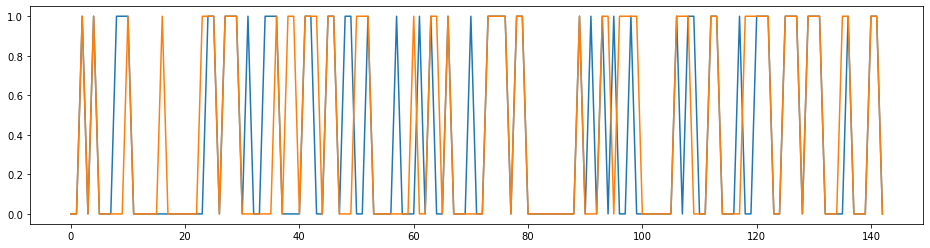

In [77]:
E_identificar_sobre_entrenamiento(ESVM_prediccion, E_validation_target)

Agregando resultados a tabla de predicción:

In [78]:
tabla_predicciones["SVM4"] = ESVM_prediccion

### 3.2.2 Experimento 2 - Features con correlación passenger_sex > 0.1

A continuación se utilizaran los features con valor de correlación mayor a 0.1 para con la columna passenger_sex:

In [79]:
ESVM_columnas = np.array(np.abs(AE_correlacion.loc["passenger_sex", E_train_features.columns])>0.1)
ESVM_svm_modelo = ESVM_SVM(E_train_features, E_train_target, ESVM_columnas)
ESVM_prediccion = ESVM_svm_modelo.predict(E_validation_features.iloc[:,ESVM_columnas])

Resultados del experimento 3:

In [80]:
ESVM_modelo_nombre = "SVM"
ESVM_cadena = "Exp2_CorrSex>0.1"
ESVM_metricas_evaluacion = E_guardar_metricas("SVM5", ESVM_prediccion, E_validation_target, ESVM_cadena, ESVM_columnas, ESVM_modelo_nombre)
ESVM_metricas_evaluacion

,ID,Fecha Hora,Modelo,Experimento,MSE,Accuracy Score,Recall Score,F1 Score,Age,SibSp,Ticket,Fare,passenger_sex,Embarked_C,Embarked_Q,Embarked_S,passenger_class_Lower,passenger_class_Middle,passenger_class_Upper
0,SVM5,2022-06-30 22:00:10.997506,SVM,Exp2_CorrSex>0.1,0.195804,0.804196,0.603448,0.714286,False,True,False,False,True,False,False,True,True,False,True


Previsualización de predicción para estimar overfit o underfit:

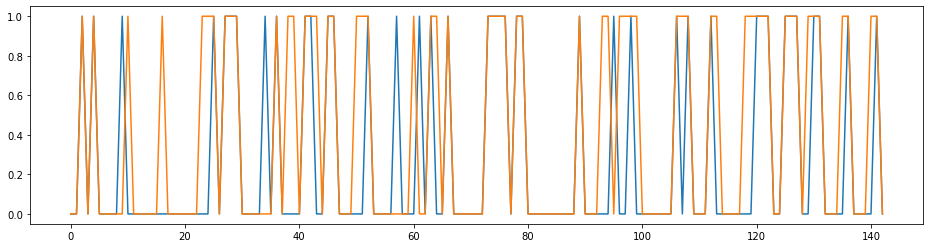

In [81]:
E_identificar_sobre_entrenamiento(ESVM_prediccion, E_validation_target)

Agregando resultados a tabla de predicción:

In [82]:
tabla_predicciones["SVM5"] = ESVM_prediccion

Guardando modelo:

In [83]:
pickle.dump(ESVM_svm_modelo, open("modelos_y_estadisticos/Model_SVM5", 'wb'))
pickle.dump(ESVM_columnas, open("modelos_y_estadisticos/Model_SVM5_ESVM_columnas", 'wb'))

## 3.3 Naive Bayes 

Función para crear el modelo Naive Bayes

In [84]:
def ENB_Naive_Bayes_modelo(ENB_nb_dataset, ENB_nb_columns):
    ENB_nb_col_y = 'passenger_survived'
    ENB_nb_evaluar = ENB_nb_dataset.iloc[:,ENB_nb_columns]
    ENB_nb_probabilidad = ENB_nb_evaluar.groupby(ENB_nb_col_y).size().div(len(ENB_nb_evaluar)) 
    ENB_nb_condicional = {}
    for col in ENB_nb_evaluar.columns:
        if( col != ENB_nb_col_y):
            ENB_nb_condicional[col] = ENB_nb_evaluar.groupby([ENB_nb_col_y, col]).size().div(len(ENB_nb_evaluar)).div(ENB_nb_probabilidad)
    return [ENB_nb_probabilidad, ENB_nb_condicional]

In [85]:
def ENB_Naive_Bayes_predecir(ENB_nbp_likelihood, ENB_nbp_probabilidad, ENB_nbp_x, ENB_nbp_columns):
    ENB_nbp_predecir = ENB_nbp_x.iloc[:,ENB_nbp_columns]
    ENB_nbp_prediccion = pd.DataFrame()
    for row in ENB_nbp_predecir.index:
        row_probabildiad0 = ENB_nbp_probabilidad[0];
        row_probabildiad1 = ENB_nbp_probabilidad[1];
        for col in ENB_nbp_predecir.columns:
            try:
                row_probabildiad0 = row_probabildiad0 * ENB_nbp_likelihood[col][0][ENB_nbp_predecir[col][row]]
                row_probabildiad1 = row_probabildiad1 * ENB_nbp_likelihood[col][1][ENB_nbp_predecir[col][row]]
            except KeyError:
                continue
        ENB_nbp_prediccion = pd.concat([ENB_nbp_prediccion, pd.DataFrame([{"N":row_probabildiad0,"Y":row_probabildiad1}])])
    return np.argmax(np.array(ENB_nbp_prediccion),axis=1)

### 3.3.1 Experimento 1 - Todos los features

Creación y predicción Naive Bayes con todas las columnas

In [86]:
ENB_columnas = np.full(len(E_data_entrenamiento.columns), True)
[ENB_probabilidad, ENB_likelihood] = ENB_Naive_Bayes_modelo(E_data_entrenamiento, ENB_columnas)

ENB_columnas = np.full(len(E_validation_features.columns), True)
ENB_prediccion = ENB_Naive_Bayes_predecir(ENB_likelihood, ENB_probabilidad, E_validation_features, ENB_columnas)

Resultados del experimento 1:

In [87]:
ENB_modelo_nombre = "Naive Bayes"
ENB_cadena = "Exp1_All"
ENB_metricas_evaluacion = E_guardar_metricas("Bayes6", ENB_prediccion, E_validation_target, ENB_cadena, ENB_columnas, ENB_modelo_nombre)
ENB_metricas_evaluacion

,ID,Fecha Hora,Modelo,Experimento,MSE,Accuracy Score,Recall Score,F1 Score,Age,SibSp,Ticket,Fare,passenger_sex,Embarked_C,Embarked_Q,Embarked_S,passenger_class_Lower,passenger_class_Middle,passenger_class_Upper
0,Bayes6,2022-06-30 22:00:11.871525,Naive Bayes,Exp1_All,0.314685,0.685315,0.689655,0.64,True,True,True,True,True,True,True,True,True,True,True


Previsualización de predicción para estimar overfit o underfit:

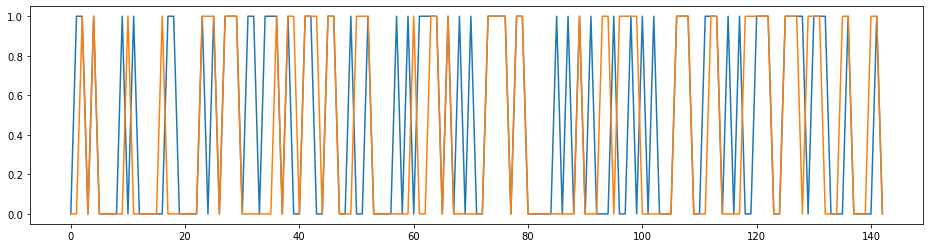

In [88]:
E_identificar_sobre_entrenamiento(ENB_prediccion, E_validation_target)

Agregando resultados a tabla de predicción:

In [89]:
tabla_predicciones["Bayes6"] = ENB_prediccion

### 3.3.2 Experimento 2 - Features con correlación passenger_sex > 0.2

A continuación se utilizaran los features con valor de correlación mayor a 0.1 para con la columna passenger_sex:

In [90]:
ENB_columnas = np.array(np.abs(AE_correlacion.loc["passenger_sex", E_data_entrenamiento.columns])>0.2)
[ENB_probabilidad, ENB_likelihood] = ENB_Naive_Bayes_modelo(E_data_entrenamiento, ENB_columnas)

ENB_columnas = np.array(np.abs(AE_correlacion.loc["passenger_sex", E_validation_features.columns])>0.2)
ENB_prediccion = ENB_Naive_Bayes_predecir(ENB_likelihood, ENB_probabilidad, E_validation_features, ENB_columnas)

Resultados del experimento 3:

In [91]:
ENB_modelo_nombre = "Naive Bayes"
ENB_cadena = "Exp2_CorrSex>0.2"
ENB_metricas_evaluacion = E_guardar_metricas("Bayes7", ENB_prediccion, E_validation_target, ENB_cadena, ENB_columnas, ENB_modelo_nombre)
ENB_metricas_evaluacion

,ID,Fecha Hora,Modelo,Experimento,MSE,Accuracy Score,Recall Score,F1 Score,Age,SibSp,Ticket,Fare,passenger_sex,Embarked_C,Embarked_Q,Embarked_S,passenger_class_Lower,passenger_class_Middle,passenger_class_Upper
0,Bayes7,2022-06-30 22:00:12.203745,Naive Bayes,Exp2_CorrSex>0.2,0.20979,0.79021,0.689655,0.727273,False,False,False,False,True,False,False,False,False,False,False


Previsualización de predicción para estimar overfit o underfit:

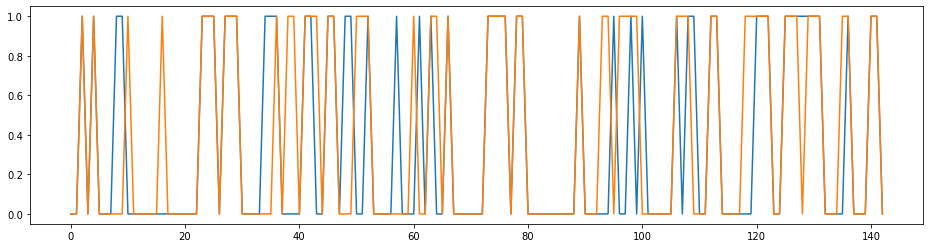

In [92]:
E_identificar_sobre_entrenamiento(ENB_prediccion, E_validation_target)

Agregando resultados a tabla de predicción:

In [93]:
tabla_predicciones["Bayes7"] = ENB_prediccion

Guardando modelo

In [94]:
pickle.dump(ENB_columnas, open("modelos_y_estadisticos/Model_Bayes7_ENB_columnas", 'wb'))
pickle.dump(ENB_probabilidad, open("modelos_y_estadisticos/Model_Bayes7_ENB_probabilidad", 'wb'))
pickle.dump(ENB_likelihood, open("modelos_y_estadisticos/Model_Bayes7_ENB_likelihood", 'wb'))

## 3.4 Regresión logística  

### 3.4.1 Modelo TensorFlow

Clase tensorflow:

In [95]:
class ModeloSigmoid:
            
    def __init__(self, x, y, columnas):
        tf.reset_default_graph()
        self.g = tf.Graph()
        
        self.columnas = columnas
        
        #Definición de variables a usar en la clase
        x = x.iloc[:,columnas]
        self.x = np.hstack(( x, np.ones((x.shape[0],1)) ))
        self.y = y
    
    def entrenar(self, experimento, lr, w, iteraciones, epochs, batch_size, lambda_):
        
        #Grafo
        with self.g.as_default():
            
            #Definición de variables
            _x = tf.Variable(tf.zeros((batch_size, self.x.shape[1])), dtype=tf.dtypes.float32, name="x")
            _y = tf.Variable(tf.zeros((batch_size, 1)), dtype=tf.dtypes.float32, name="y")
            _w = tf.Variable(tf.zeros((self.x.shape[1], 1)), dtype=tf.dtypes.float32, name="w")
            _lr = tf.Variable(0.0, dtype=tf.dtypes.float32, name="lr")
            _lambda = tf.Variable(0.0, dtype=tf.dtypes.float32, name="lambda")
            
            #Cálculo de perdida
            with tf.name_scope("perdida"):
                logits = tf.matmul(_x, _w, name="logits")
                error = tf.nn.sigmoid_cross_entropy_with_logits(labels=_y, logits=logits, name="error")
                regularicion = tf.math.multiply(
                    _lambda,
                    tf.reduce_sum(
                        tf.pow(
                            tf.slice(_w, begin=[0,0], size=[self.x.shape[1]-1, 1]), 
                            2.0
                        )
                        
                    ),
                    name ="regularizacion"
                )
                perdida = tf.reduce_mean(
                    tf.math.add(error, regularicion), 
                    name="perdida_1"
                )
            
            #Gradiente
            with tf.name_scope("gradiente"):
                gradiente = tf.gradients(perdida, [_w], name="gradiente")
            
            #Recalculo de pesos
            with tf.name_scope("reajuste_pesos"):
                reajuste = tf.subtract(_w, tf.multiply(_lr,gradiente[0]), name="reajuste")
            
            #Predicción
            with tf.name_scope("prediccion_calculo"):
                yhat = tf.matmul(_x, reajuste, name="yhat")
                p = tf.math.sigmoid(yhat, name="probabilidad")
                mascara = tf.math.greater(p, 0.5, name="mascara")
                prediccion = tf.cast(mascara, tf.dtypes.int16, name="prediccion")
            
        #Sesión
        with tf.Session(graph=self.g) as sesion:
            #Escritura de log
            writer = tf.summary.FileWriter(
                os.path.join(
                    "./logs", 
                    experimento+"_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                ), 
                sesion.graph
            )
            
            #Iteraciones
            for iteracion in range(iteraciones):
                #Epochs
                for epoch in range(epochs):
                    #Tamaño de muestra
                    muestra_inicio = batch_size*epoch
                    muestra_fin = muestra_inicio+batch_size
                    
                    #TensorFlow
                    [tf_perdida, w, yhat_batch, tf_prediccion, tf_regularicion] = sesion.run([perdida, reajuste, _y, prediccion, regularicion], feed_dict = {
                        _x: self.x[muestra_inicio:muestra_fin,:],
                        _y: self.y[muestra_inicio:muestra_fin],
                        _w: w,
                        _lr: lr,
                        _lambda: lambda_
                    }) 
                    
                    #Cálculo de presición
                    precision = accuracy_score(np.array(yhat_batch), tf_prediccion)
                    
                    #Escribiendo en TensorBoard
                    writer.add_summary( tf.Summary(value=[tf.Summary.Value(tag="precision", simple_value=precision)]), iteracion*epochs + epoch)
                    writer.add_summary( tf.Summary(value=[tf.Summary.Value(tag="perdida", simple_value=tf_perdida)]), iteracion*epochs + epoch)
                    
                
            writer.close()
        
        #Retornando pesos
        return w
        
    def prediccion(self, x, w):
        x = x.iloc[:, self.columnas]
        x_ = np.hstack(( x, np.ones((x.shape[0],1)) ))
        yhat = tf.matmul(x_, w)
        p = tf.math.sigmoid(yhat)
        return np.array(p>0.5).astype(int)

Grafo de TensorFlow

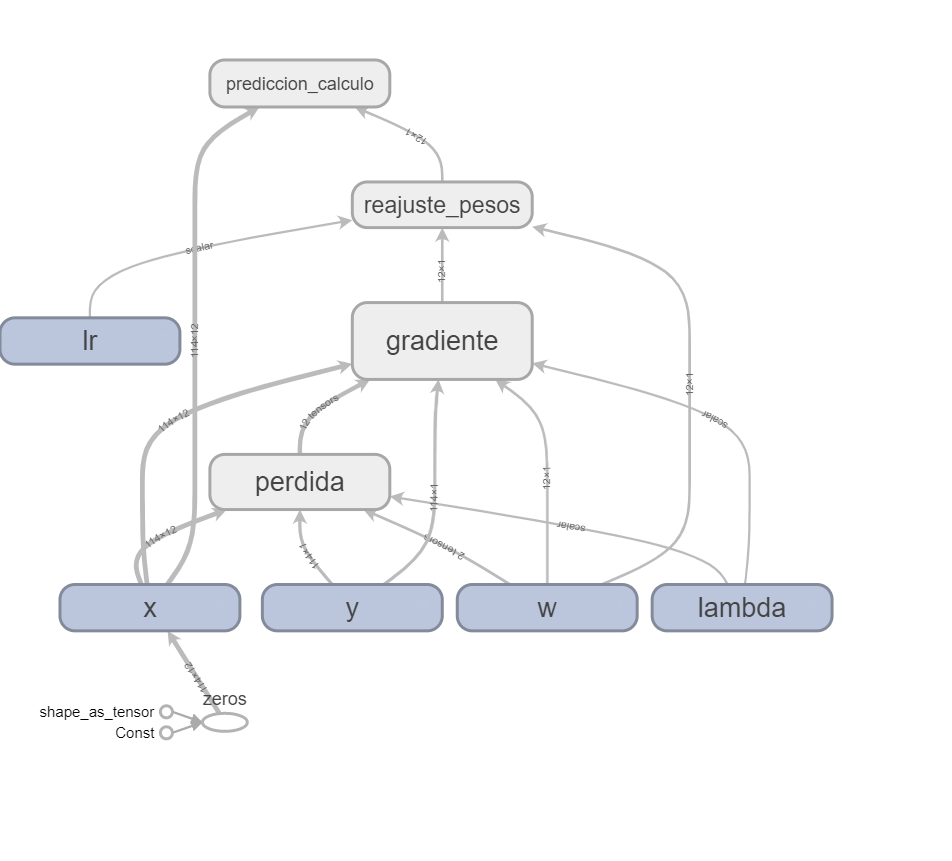

In [96]:
Image(filename='grafo.png')

### 3.4.2 Experimento 1 - Todos los features

Creación y predicción utilizando regresión logística con todas las columnas

In [97]:
ERL_columnas = np.full(len(E_train_features.columns), True)
ERL_modelo_sigmoid_1 = ModeloSigmoid(E_train_features, E_train_target, ERL_columnas)

lr_ = 0.1
w_ = np.zeros((E_train_features.shape[1]+1, 1))
iteraciones_ = 80
epochs_ = 5
batch_size_ = int(len(E_train_features)/epochs_)
lambda__ = 0.1
ERL_string_exp = "E1_lr001_i100_e5_l0.01"
ERL_exp1 = ERL_modelo_sigmoid_1.entrenar(ERL_string_exp, lr_, w_, iteraciones_, epochs_, batch_size_, lambda__)
ERL_prediccion = ERL_modelo_sigmoid_1.prediccion(E_validation_features, ERL_exp1)

Resultados del experimento 1:

In [98]:
ERL_modelo_nombre = "Regresión logistica"
ERL_cadena = "Exp1_All_"+ERL_string_exp
ERL_metricas_evaluacion = E_guardar_metricas("RLog8", ERL_prediccion, E_validation_target, ERL_cadena, ERL_columnas, ERL_modelo_nombre)
ERL_metricas_evaluacion

,ID,Fecha Hora,Modelo,Experimento,MSE,Accuracy Score,Recall Score,F1 Score,Age,SibSp,Ticket,Fare,passenger_sex,Embarked_C,Embarked_Q,Embarked_S,passenger_class_Lower,passenger_class_Middle,passenger_class_Upper
0,RLog8,2022-06-30 22:00:13.479347,Regresión logistica,Exp1_All_E1_lr001_i100_e5_l0.01,0.20979,0.79021,0.637931,0.711538,True,True,True,True,True,True,True,True,True,True,True


Previsualización de predicción para estimar overfit o underfit:

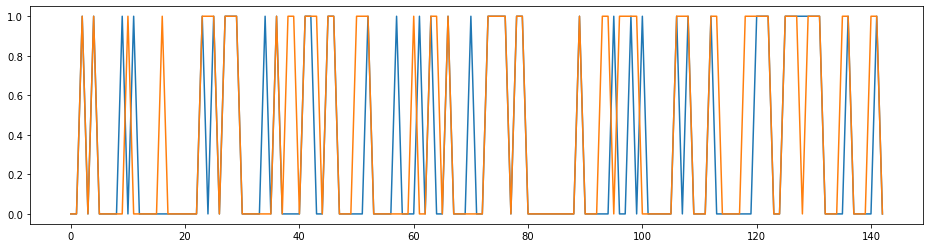

In [99]:
E_identificar_sobre_entrenamiento(ERL_prediccion, E_validation_target)

Gráfica de perdida de TensorBoard

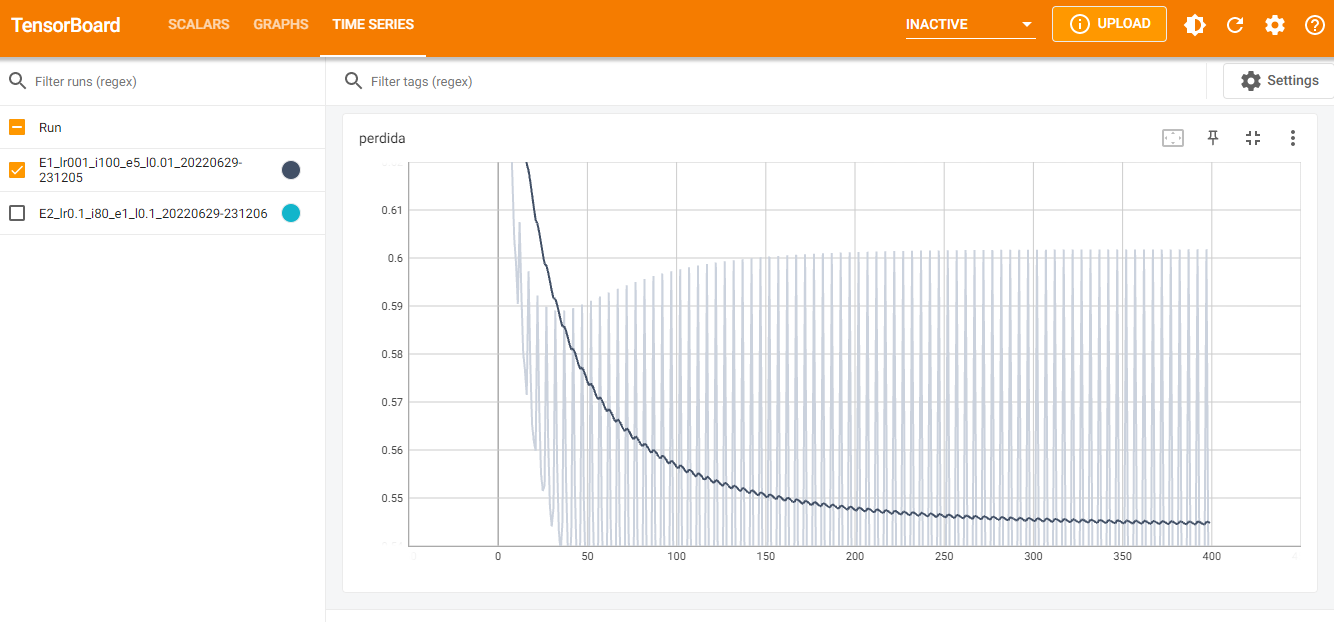

In [100]:
Image(filename='exp1_perdida.png')

Gráfica de presición de TensorBoard

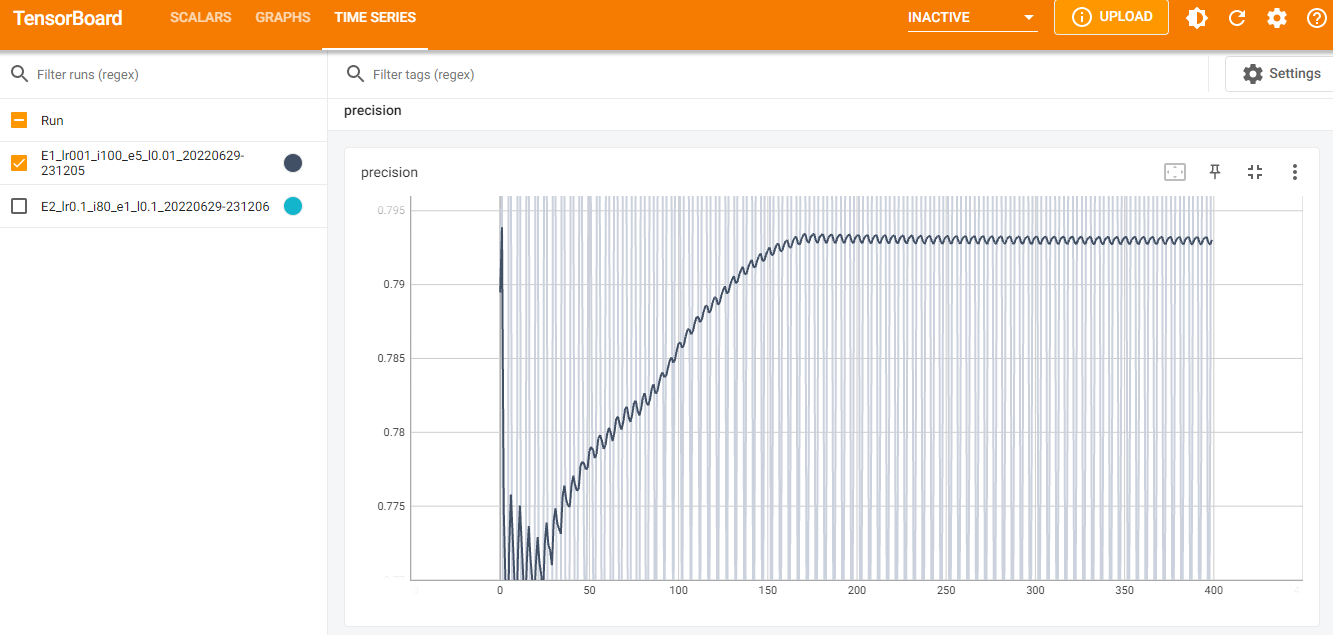

In [101]:
Image(filename='exp1_presicion.png')

Agregando resultados a tabla de predicción:

In [102]:
tabla_predicciones["RLog8"] = ERL_prediccion

### 3.4.3 Experimento 2 - Features con correlación passenger_sex > 0.1

A continuación se utilizaran los features con valor de correlación mayor a 0.1 para con la columna passenger_sex:

In [103]:
ERL_columnas = np.array(np.abs(AE_correlacion.loc["passenger_sex", E_train_features.columns])>0.1)
ERL_modelo_sigmoid_2 = ModeloSigmoid(E_train_features, E_train_target, ERL_columnas)

lr_ = 0.1
w_ = np.zeros((E_train_features.iloc[:,ERL_columnas].shape[1]+1, 1))
iteraciones_ = 80
epochs_ = 1
batch_size_ = int(len(E_train_features)/epochs_)
lambda__ = 0.1
ERL_string_exp = "E2_lr0.1_i80_e1_l0.1"
ERL_exp2 = ERL_modelo_sigmoid_2.entrenar(ERL_string_exp, lr_, w_, iteraciones_, epochs_, batch_size_, lambda__)
ERL_prediccion = ERL_modelo_sigmoid_2.prediccion(E_validation_features, ERL_exp2)

Resultados del experimento 2:

In [104]:
ERL_modelo_nombre = "Regresión logistica"
ERL_cadena = "Exp2_CorrSex>0.1"+ERL_string_exp
ERL_metricas_evaluacion = E_guardar_metricas("RLog9", ERL_prediccion, E_validation_target, ERL_cadena, ERL_columnas, ERL_modelo_nombre)
ERL_metricas_evaluacion

,ID,Fecha Hora,Modelo,Experimento,MSE,Accuracy Score,Recall Score,F1 Score,Age,SibSp,Ticket,Fare,passenger_sex,Embarked_C,Embarked_Q,Embarked_S,passenger_class_Lower,passenger_class_Middle,passenger_class_Upper
0,RLog9,2022-06-30 22:00:14.162980,Regresión logistica,Exp2_CorrSex>0.1E2_lr0.1_i80_e1_l0.1,0.20979,0.79021,0.62069,0.705882,False,True,False,False,True,False,False,True,True,False,True


Previsualización de predicción para estimar overfit o underfit:

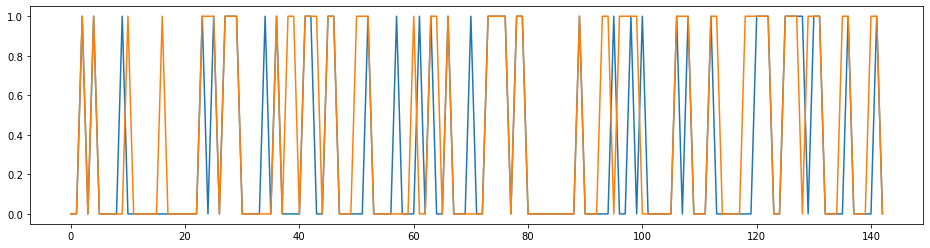

In [105]:
E_identificar_sobre_entrenamiento(ERL_prediccion, E_validation_target)

Gráfica de perdida de TensorBoard

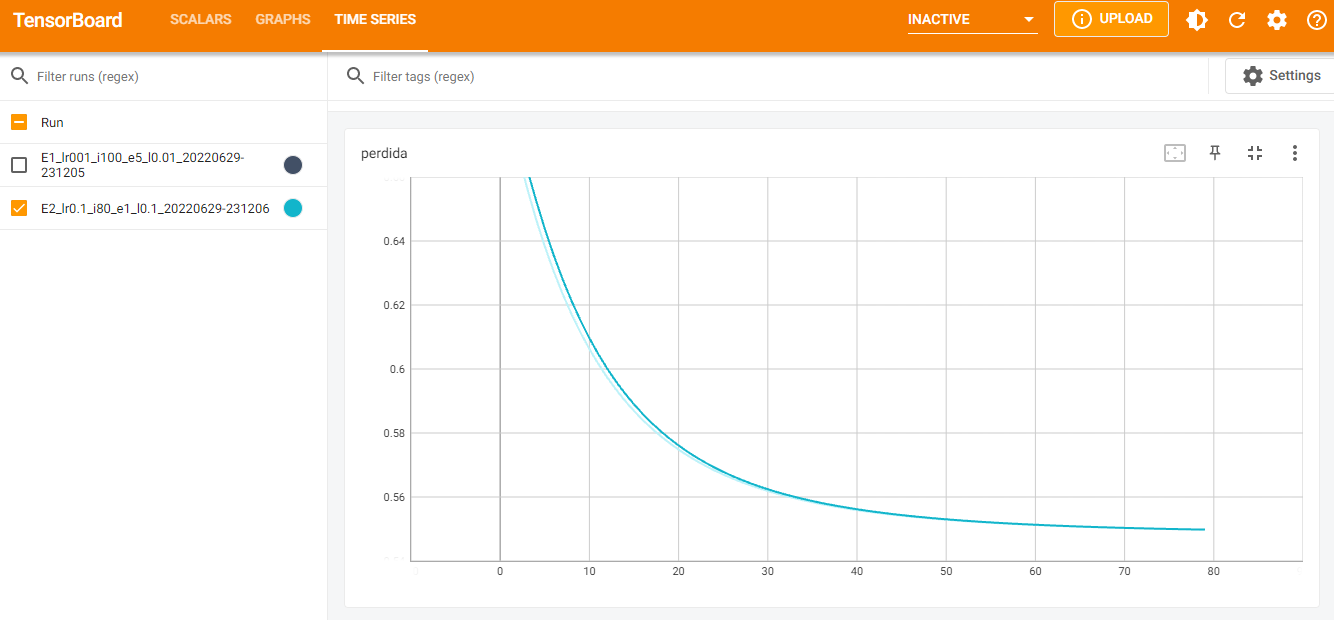

In [106]:
Image(filename='exp2_perdida.png')

Gráfica de presición de TensorBoard

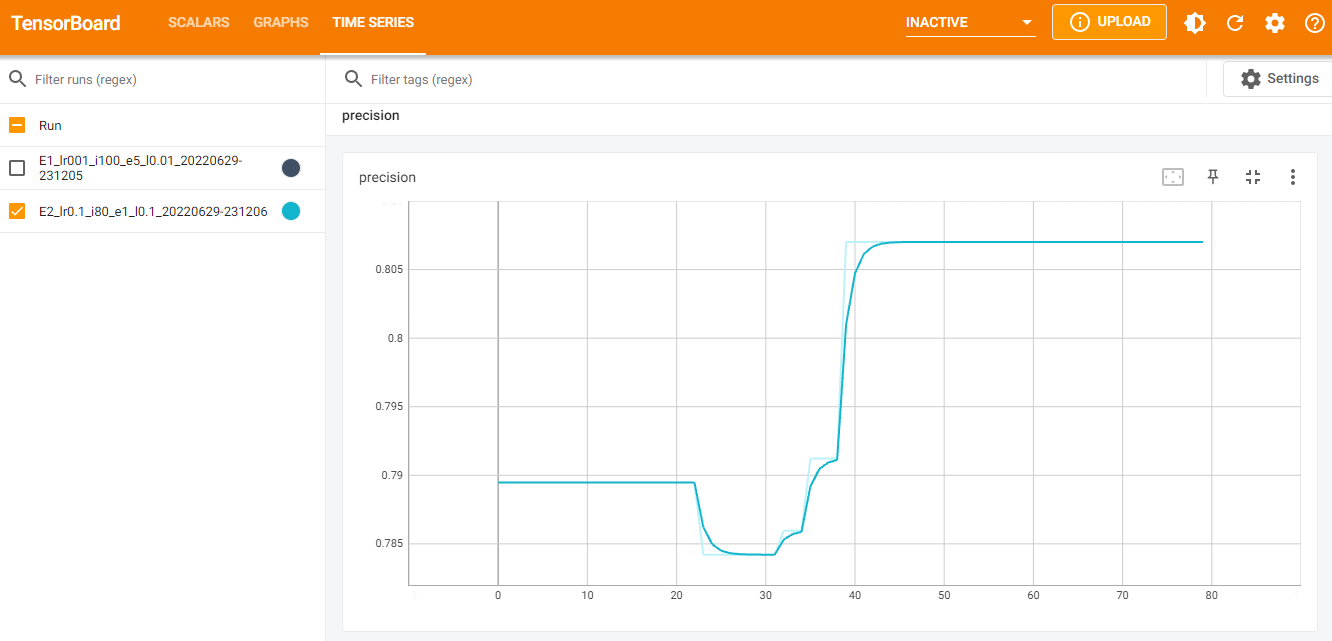

In [107]:
Image(filename='exp2_presicion.png')

Agregando resultados a tabla de predicción:

In [108]:
tabla_predicciones["RLog9"] = ERL_prediccion

Guardando modelo

In [109]:
pickle.dump(ERL_exp2, open("modelos_y_estadisticos/Model_RLog9_ERL_exp2_w", 'wb'))
pickle.dump(ERL_columnas, open("modelos_y_estadisticos/Model_RLog9_ERL_columnas", 'wb'))

# 4. Tabla de métricas de evaluación

In [110]:
metricas = pd.read_csv("experimentos.csv").T
metricas.columns = metricas.iloc[0] 
metricas = metricas[1:]
metricas

ID,Tree1,Tree2,Tree3,SVM4,SVM5,Bayes6,Bayes7,RLog8,RLog9
Fecha Hora,2022-06-30 22:00:10.071294,2022-06-30 22:00:10.278154,2022-06-30 22:00:10.515521,2022-06-30 22:00:10.762188,2022-06-30 22:00:10.997506,2022-06-30 22:00:11.871525,2022-06-30 22:00:12.203745,2022-06-30 22:00:13.479347,2022-06-30 22:00:14.162980
Modelo,Decision Tree,Decision Tree,Decision Tree,SVM,SVM,Naive Bayes,Naive Bayes,Regresión logistica,Regresión logistica
Experimento,Exp1_All,Exp2_Corr>0.5,Exp3_CorrSex>0.1,Exp1_All,Exp2_CorrSex>0.1,Exp1_All,Exp2_CorrSex>0.2,Exp1_All_E1_lr001_i100_e5_l0.01,Exp2_CorrSex>0.1E2_lr0.1_i80_e1_l0.1
MSE,0.237762,0.20979,0.202797,0.216783,0.195804,0.314685,0.20979,0.20979,0.20979
Accuracy Score,0.762238,0.79021,0.797203,0.783217,0.804196,0.685315,0.79021,0.79021,0.79021
Recall Score,0.689655,0.689655,0.603448,0.706897,0.603448,0.689655,0.689655,0.637931,0.62069
F1 Score,0.701754,0.727273,0.707071,0.725664,0.714286,0.64,0.727273,0.711538,0.705882
Age,True,False,False,True,False,True,False,True,False
SibSp,True,False,True,True,True,True,False,True,True
Ticket,True,False,False,True,False,True,False,True,False


# 5. Investigacion k-fold cross validation 

Es un analisis más robusto y permite entrenar y validar el modelo con toda la información. Al utilizar validación cruzada (cross validation, k-fold), se asegura de no omitir nada, y se evitan sezgos u outliers en el modelo final. 

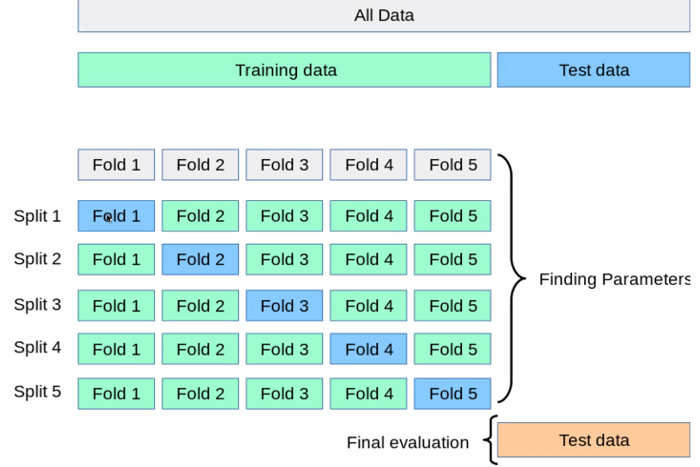

In [111]:
Image(filename='kfold.png')

En la imagen es posible ver que al utilizar k-fold, el modelo se entrena con cada split, y cada split tendrá un fold que servirá para realizar la validación.
<br/>
<br/>
En este proyecto se pudo haber utilizado en el algoritmo de regresión logística, se hace un ciclo for de n=splits iteraciones, el set de datos se separa en m=folds, y en cada iteración se llama al algoritmo con los pesos actuales y se utiliza set[n] para validación y merge(set[0:n], set[n+1:-1] para entrenamiento.

# 6. Tabla de predicciones

In [112]:
tabla_predicciones

,Y,Tree1,Tree2,Tree3,SVM4,SVM5,Bayes6,Bayes7,RLog8,RLog9
105,0,0,0,0,0,0,0,0,0,0
850,0,0,0,0,0,0,1,0,0,0
546,1,1,1,1,1,1,1,1,1,1
223,0,0,0,0,0,0,0,0,0,0
255,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
822,0,0,0,0,0,0,0,0,0,0
117,0,0,0,0,0,0,0,0,0,0
141,1,0,1,0,1,0,0,1,0,0
700,1,1,1,1,1,1,1,1,1,1


# 7. Predicción final

In [113]:
prediccion_final = tabla_predicciones[["Tree3", "SVM5", "Bayes7", "RLog9"]].mode(axis=1).loc[:,0]
pd.DataFrame([{
    'MSE': mean_squared_error(np.array(E_validation_target), prediccion_final),
    'Accuracy Score': accuracy_score(np.array(E_validation_target),prediccion_final),
    'Recall Score': recall_score(np.array(E_validation_target), prediccion_final),
    'F1 Score': f1_score(np.array(E_validation_target), prediccion_final)
}])

,MSE,Accuracy Score,Recall Score,F1 Score
0,0.195804,0.804196,0.603448,0.714286
